# **1. Install and Import Dependencies**

In [20]:
!pip3 install transformers
!pip3 install datasets
!pip3 install evaluate

In [1]:
# Nick

import torch

# Do some computations with CUDA tensors
a = torch.randn(1000, 1000, device='cuda')
b = torch.randn(1000, 1000, device='cuda')
c = torch.matmul(a, b)

# Clear the CUDA memory
torch.cuda.empty_cache()

# Check the current memory usage
print(f"Current CUDA memory usage: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

Current CUDA memory usage: 11.44 MB
cuda


# **2. Load dataset**

In [2]:
# Nick

from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
import pandas as pd
import numpy as np
import os

# put csv file in pandas dataframe
df = pd.read_csv('IMDB Dataset.csv')
df['sentiment'] = np.where(df['sentiment'] == "positive", 1, df['sentiment'])
df['sentiment'] = np.where(df['sentiment'] == "negative", 0, df['sentiment'])

df_train = df[:int(len(df)*0.8)]
df_test  = df[int(len(df)*0.8):]

# put dataframes into Dataset format
raw_train_dataset = Dataset.from_pandas(df_train)
raw_test_dataset = Dataset.from_pandas(df_test)

# initialize tokenizer to the chosen model
checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
  return tokenizer(example['review'], truncation=True)

# tokenize train and test datasets using tokenize_function
tokenized_train_dataset = raw_train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset =  raw_test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [3]:
# Nick

# rename classification column to "labels" for acceptable tensor format
tokenized_train_dataset = tokenized_train_dataset.rename_column("sentiment", "labels")
tokenized_test_dataset = tokenized_test_dataset.rename_column("sentiment", "labels")
print(tokenized_train_dataset)
print(tokenized_test_dataset)

Dataset({
    features: ['review', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 40000
})
Dataset({
    features: ['review', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 10000
})


In [9]:
# Nick

# remove "review" column to maintain acceptable tensor format
tokenized_train_dataset = tokenized_train_dataset.remove_columns(["review"])
tokenized_test_dataset = tokenized_test_dataset.remove_columns(["review"])
print(tokenized_train_dataset)
print(tokenized_test_dataset)

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 40000
})
Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 10000
})


In [10]:
# Nick

# change datatype to pytorch tensor for train and test datasets
tokenized_train_dataset.set_format("torch")
tokenized_test_dataset.set_format("torch")
print(tokenized_train_dataset)

# initialize data collator
data_collator = DataCollatorWithPadding(tokenizer)

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 40000
})


In [12]:
# Nick

from torch.utils.data import DataLoader
# load data into DataLoaders for training/validation
train_dataloader = DataLoader(
    tokenized_train_dataset, shuffle=True, batch_size=8, collate_fn=data_collator, 
)

test_dataloader = DataLoader(
    tokenized_test_dataset, batch_size = 8, collate_fn=data_collator
)

In [13]:
# Matt

# print example of train_dataloader content
for batch in train_dataloader:
  break
print({k: v.shape for k,v in batch.items()})

{'labels': torch.Size([8]), 'input_ids': torch.Size([8, 512]), 'token_type_ids': torch.Size([8, 512]), 'attention_mask': torch.Size([8, 512])}


# **2. Instantiate Model**

In [14]:
# Matt

from transformers import AutoModelForSequenceClassification
checkpoint = "bert-base-cased"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [15]:
# Matt

batch = batch.to(device)
outputs = model(**batch)
print(outputs.loss, outputs.logits.shape)

tensor(0.4283, device='cuda:0', grad_fn=<NllLossBackward0>) torch.Size([8, 2])


In [16]:
# Matt

# initialize optimizer
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

C:\Users\Alex\anaconda3\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [18]:
# Matt

# initialize learning rate scheduler
from transformers import get_scheduler

num_epochs = 5
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

In [19]:
# Alex

# train and evaluate model over epochs
from tqdm.auto import tqdm
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import evaluate

progress_bar = tqdm(range(num_training_steps))

epoch_train_loss = []
epoch_val_loss = []

for epoch in range(num_epochs):
    # train
    train_loss = []
    model.train()
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        train_loss.append(loss.item())
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    
    print("Epoch {} Avg train loss: {}".format(epoch, np.mean(train_loss)))
    epoch_train_loss.append(np.mean(train_loss))
    
    # eval
    val_loss = []
    model.eval()
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        
        loss = outputs.loss
        val_loss.append(loss.item())
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
    
    print("Epoch {} Avg val loss: {}".format(epoch, np.mean(val_loss)))
    epoch_val_loss.append(np.mean(val_loss))

  0%|          | 0/25000 [00:00<?, ?it/s]

Epoch 0 Avg train loss: 0.31396595117058607
Epoch 0 Avg val loss: 0.23486960103809834
Epoch 1 Avg train loss: 0.17609071564199402
Epoch 1 Avg val loss: 0.21019132185503842
Epoch 2 Avg train loss: 0.09632230943271425
Epoch 2 Avg val loss: 0.21150592316351832
Epoch 3 Avg train loss: 0.04491714916042983
Epoch 3 Avg val loss: 0.2783908742349595
Epoch 4 Avg train loss: 0.022629215787048452
Epoch 4 Avg val loss: 0.2967100749380421


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


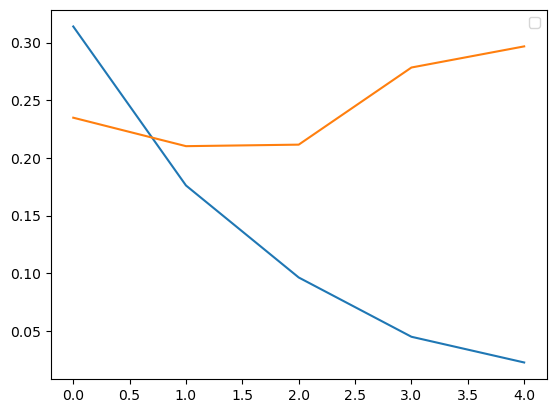

In [20]:
# Alex
# visualize loss ratios using line chart
import matplotlib.pyplot as plt


plt.plot(epoch_train_loss)
plt.plot(epoch_val_loss)
plt.legend()
plt.show()


# **3. Encode and Calculate Sentiment**

In [ ]:
# Alex

# test the model with an example
tokens = tokenizer.encode("I hated this movie, it was worse than the second film.", return_tensors='pt')
result = model(tokens.to(device))
result.logits
int(torch.argmax(result.logits))

# **5. Evaluation**

In [23]:
# Matt and Alex

# do final evaluation on fine-tuned model
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import evaluate

# initialize evaluation functions
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

model.eval()

# create arrays for confusion matrix data
y_true = []
y_pred = []
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    accuracy_metric.add_batch(predictions=predictions, references=batch["labels"])
    precision_metric.add_batch(predictions=predictions, references=batch["labels"])
    recall_metric.add_batch(predictions=predictions, references=batch["labels"])

    # add batch to confusion matrix arrays
    y_true.extend(batch["labels"].tolist())
    y_pred.extend(predictions.tolist())

print("Accuracy:", accuracy_metric.compute())
print("Precision:", precision_metric.compute())
print("Recall:", recall_metric.compute())

Accuracy: {'accuracy': 0.9282}
Precision: {'precision': 0.9334950475035375}
Recall: {'recall': 0.9223087677251848}


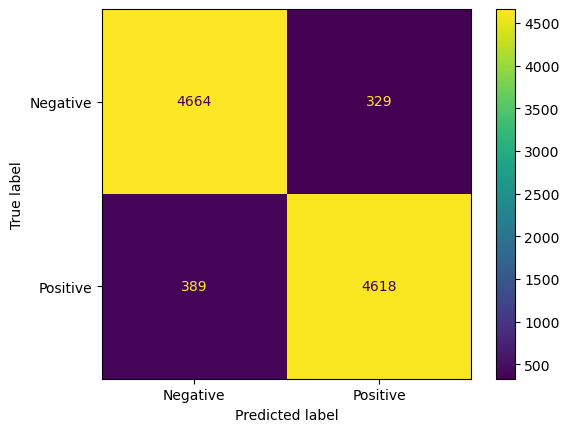

In [24]:
# Alex

# Calculate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
display.plot()

In [25]:
# Alex

import joblib

# save the model to disk
filename = './new_finetuned_model.sav'

#model, tokenizer = joblib.load('./finetuned_model.sav')
model.to("cpu")

joblib.dump(value=[model, tokenizer], filename=filename, compress=0)



['./new_finetuned_model.sav']